用户评论质量预测

# 比赛介绍

### 案例背景

随着电商平台的兴起，以及疫情的持续影响，线上购物在我们的日常生活中扮演着越来越重要的角色。在进行线上商品挑选时，评论往往是我们十分关注的一个方面。然而目前电商网站的评论质量参差不齐，甚至有水军刷好评或者恶意差评的情况出现，严重影响了顾客的购物体验。因此，对于评论质量的预测成为电商平台越来越关注的话题，如果能自动对评论质量进行评估，就能根据预测结果避免展现低质量的评论。本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。

### 任务

本案例中需要完成两种集成学习算法的实现（Bagging、AdaBoost.M1），其中基分类器要求使用 SVM 和决策树两种，因此，一共需要对比四组结果（[AUC](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) 作为评价指标）：

* Bagging + SVM
* Bagging + 决策树
* AdaBoost.M1 + SVM
* AdaBoost.M1 + 决策树

注意集成学习的核心算法需要**手动进行实现**，基分类器可以调库。

### 基本要求

* 根据数据格式设计特征的表示
* 汇报不同组合下得到的 AUC
* 结合不同集成学习算法的特点分析结果之间的差异
* （使用 sklearn 等第三方库的集成学习算法会酌情扣分）

### 扩展要求

* 尝试其他基分类器（如 k-NN、朴素贝叶斯）
* 分析不同特征的影响
* 分析集成学习算法参数的影响
* 尝试各种方法提升排行榜上预测性能


### 数据描述

本次数据来源于 Amazon 电商平台，包含超过 50,000 条用户在购买商品后留下的评论，各列的含义如下：

* reviewerID：用户 ID
* asin：商品 ID
* reviewText：英文评论文本
* overall：用户对商品的打分（1-5）
* votes_up：认为评论有用的点赞数（只在训练集出现）
* votes_all：该评论得到的总评价数（只在训练集出现）
* label：评论质量的 label，1 表示高质量，0 表示低质量（只在训练集出现）

评论质量的 label 来自于其他用户对评论的 votes，votes_up/votes_all ≥ 0.9 的作为高质量评论。此外测试集包含一个额外的列`Id`，标识了每一个测试的样例。

### 文件说明

* train.csv：训练集
* test.csv：测试集，用户和商品保证在训练集中出现过，没有关于 votes 和 label 的列

文件使用 \t 分隔，可以使用 pandas 进行读取：

```python
import pandas as pd
train_df = pd.read_csv('train.csv', sep='\t')
```

### 提交格式

提交文件需要对测试集中每一条评论给出预测为高质量的**概率**，每行包括一个`Id`（和测试集对应）以及预测的概率`Predicted`（0-1的浮点数），用逗号分隔。示例提交格式如下：

```
Id,Predicted
0,0.9
1,0.45
2,0.78
...
```

提交文件需要命名为`result.csv`

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import catboost
import itertools
from argparse import Namespace

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

## 原始数据集

In [2]:
train_data_path = 'data/train.csv'
test_data_path = 'data/test.csv'

In [3]:
raw_train_df = pd.read_csv(train_data_path, sep='\t')
raw_test_df = pd.read_csv(test_data_path, sep='\t')

In [4]:
raw_train_df.head()

,reviewerID,asin,reviewText,overall,votes_up,votes_all,label
0,7885,3901,"First off, allow me to correct a common mistak...",5.0,6,7,0
1,52087,47978,I am really troubled by this Story and Enterta...,3.0,99,134,0
2,5701,3667,A near-perfect film version of a downright glo...,4.0,14,14,1
3,47191,40892,Keep your expectations low. Really really low...,1.0,4,7,0
4,40957,15367,"""they dont make em like this no more...""well.....",5.0,3,6,0


In [5]:
raw_test_df.head()

,Id,reviewerID,asin,reviewText,overall
0,0,82947,37386,I REALLY wanted this series but I am in SHOCK ...,1.0
1,1,10154,23543,I have to say that this is a work of art for m...,4.0
2,2,5789,5724,Alien 3 is certainly the most controversal fil...,3.0
3,3,9198,5909,"I love this film...preachy? Well, of course i...",5.0
4,4,33252,21214,Even though I previously bought the Gamera Dou...,5.0


商品、用户集合在训练集和测试集的关系：

In [6]:
print(set(raw_test_df.reviewerID.unique()).issubset(set(raw_train_df.reviewerID.unique())))
print(set(raw_test_df.asin.unique()).issubset(set(raw_train_df.asin.unique())))

True
True


因此，测试集的用户、商品是训练集的子集。

合并训练集和测试集

In [7]:
cols = ['reviewerID', 'asin', 'reviewText', 'overall', 'label']
raw_test_df['label'] = -1
df = pd.concat([raw_train_df[cols], raw_test_df[cols]])

## 特征工程

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68247 entries, 0 to 11207
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewerID  68247 non-null  int64  
 1   asin        68247 non-null  int64  
 2   reviewText  68247 non-null  object 
 3   overall     68247 non-null  float64
 4   label       68247 non-null  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ MB


* 共68247条记录，其中训练集57039条，测试集11208条
* 不存在缺失记录
* 文本特征：reviewText，数值特征：reviewID, asin, overall

原始特征

* reviewerID：用户 ID
* asin：商品 ID
* reviewText：英文评论文本
* overall：用户对商品的打分（1-5）
* label：评论质量的 label，1 表示高质量，0 表示低质量（只在训练集出现）

用户ID

In [9]:
len(df[df.label!=-1].reviewerID.unique())

5758

商品ID

In [10]:
len(df[df.label!=-1].asin.unique())

22465

count特征

In [11]:
def count_feat(df: pd.DataFrame, feats: list):
    for feat in feats:
        series = df[df.label!=-1][feat].value_counts()
        tmp_df = pd.DataFrame({
            feat:series.index,
            feat + '_count': series.values
        })

        df = pd.merge(df, tmp_df, how='left', on=feat)
        
    return df

In [12]:
count_feats = ['reviewerID', 'asin']

df = count_feat(df, count_feats)

In [13]:
df.head(3)

,reviewerID,asin,reviewText,overall,label,reviewerID_count,asin_count
0,7885,3901,"First off, allow me to correct a common mistak...",5.0,0,33,5
1,52087,47978,I am really troubled by this Story and Enterta...,3.0,0,6,4
2,5701,3667,A near-perfect film version of a downright glo...,4.0,1,29,1


商品评分特征

In [14]:
df[df.label!=-1].overall.value_counts()

5.0    23365
4.0    10104
1.0     9970
3.0     7232
2.0     6368
Name: overall, dtype: int64

<AxesSubplot:>

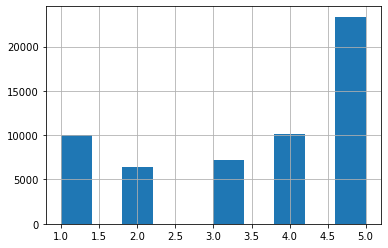

In [15]:
df[df.label!=-1].overall.hist()

用户评分、商品评分的交叉特征

In [16]:
tmp = df.groupby('reviewerID')[['overall']].aggregate(['mean', 'min', 'max', 'std'])
tmp.columns = ['cross_overall_userid_mean', 'cross_overall_userid_min',
               'cross_overall_userid_max', 'cross_overall_userid_std']
df = df.merge(tmp, on='reviewerID', how='left')

In [17]:
cross_overall_userid_feats = ['cross_overall_userid_mean', 'cross_overall_userid_min',
                              'cross_overall_userid_max', 'cross_overall_userid_std']

In [18]:
tmp = df.groupby('asin')[['overall']].aggregate(['mean', 'min', 'max', 'std'])
tmp.columns = ['cross_overall_asin_mean', 'cross_overall_asin_min',
               'cross_overall_asin_max', 'cross_overall_asin_std']
tmp.fillna(0, inplace=True)
df = df.merge(tmp, on='asin', how='left')

In [19]:
cross_overall_asin_feats = ['cross_overall_asin_mean', 'cross_overall_asin_min',
                            'cross_overall_asin_max', 'cross_overall_asin_std']

评论特征

Bag of Words Vectorizer

In [20]:
corpus = [review for review in df.reviewText]

In [21]:
%%time

NGRAM = 2

count_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=0.01, ngram_range=(1, NGRAM))
review_count_vector = count_vectorizer.fit_transform(corpus)

CPU times: user 21.3 s, sys: 584 ms, total: 21.9 s
Wall time: 21.9 s


In [22]:
print('Vocabulary size: %d' % len(count_vectorizer.vocabulary_))

Vocabulary size: 1768


In [23]:
review_count_df = pd.DataFrame(review_count_vector.toarray(),
                               columns=['review_' + str(i) for i in range(len(count_vectorizer.vocabulary_))])

In [24]:
review_feats = list(review_count_df.columns)

In [25]:
df = pd.concat([df, review_count_df], 1)

## 准备数据集

In [26]:
train_df = df[df.label!=-1]
test_df = df[df.label==-1]

In [27]:
train_df.shape, test_df.shape

((57039, 1783), (11208, 1783))

In [28]:
features = list(itertools.chain(['reviewerID', 'asin', 'overall', 'reviewerID_count', 'asin_count'],
                          review_feats, cross_overall_asin_feats, cross_overall_userid_feats))

In [29]:
X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df['label'],
                                                  test_size=0.2, random_state=42)

In [30]:
print('train dataset X: %s, y: %s' % (X_train.shape, y_train.shape))
print('val   dataset X: %s, y: %s' % (X_val.shape, y_val.shape))

train dataset X: (45631, 1781), y: (45631,)
val   dataset X: (11408, 1781), y: (11408,)


## 模型

### sklearn模型

#### sklearn random forest

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [41]:
rf_model = RandomForestClassifier(n_estimators=2000, max_depth=10, min_samples_leaf=20, random_state=42, 
                                  n_jobs=12, verbose=1)

In [42]:
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    3.5s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    8.3s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   15.1s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:   24.2s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:   34.9s
[Parallel(n_jobs=12)]: Done 2000 out of 2000 | elapsed:   39.1s finished


RandomForestClassifier(max_depth=10, min_samples_leaf=20, n_estimators=2000,
                       n_jobs=12, random_state=42, verbose=1)

In [52]:
y_pred = rf_model.predict_proba(X_val)[:, 1]

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1776 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 2000 out of 2000 | elapsed:    0.6s finished


In [53]:
y_val.shape, y_pred.shape

((11408,), (11408,))

In [54]:
roc_auc_score(y_val, y_pred)

0.8092325750124508

#### sklearn bagging

In [60]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [85]:
params = Namespace(
    n_estimators=2000,
    random_state=42,
    max_depth=10,
    min_samples_leaf=20,
    verbose=1,
    n_jobs=12,
    learning_rate=1e-2
)

In [82]:
tree_base_model = DecisionTreeClassifier(max_depth=params.max_depth,
                                         min_samples_leaf=params.min_samples_leaf,
                                         random_state=params.random_state)

In [78]:
tree_bagging_model = BaggingClassifier(base_estimator=tree_base_model,
                                       n_estimators=params.n_estimators, 
                                       random_state=params.random_state,
                                       n_jobs=params.n_jobs,
                                       verbose=params.verbose)

In [79]:
tree_bagging_model.fit(X_train, y_train)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed: 37.4min remaining: 186.9min
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed: 37.6min finished


BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                        min_samples_leaf=20,
                                                        random_state=42),
                  n_estimators=2000, n_jobs=12, random_state=42, verbose=1)

In [80]:
y_pred = tree_bagging_model.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:   55.7s remaining:  4.6min
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   57.4s finished


0.8159884936426698

#### sklearn boosting

In [81]:
from sklearn.ensemble import AdaBoostClassifier

In [83]:
tree_base_model = DecisionTreeClassifier(max_depth=params.max_depth,
                                         min_samples_leaf=params.min_samples_leaf,
                                         random_state=params.random_state)

In [87]:
boosting_model = AdaBoostClassifier(tree_base_model,
                                    learning_rate=params.learning_rate,
                                    n_estimators=params.n_estimators,
                                    random_state=params.random_state)

In [89]:
# boosting_model.fit(X_train, y_train)

### 动手实现算法

#### Bagging

In [150]:
# encoding: utf8

import copy
import time
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


class MyBaggingClassifier(object):
    """Bagging classifier."""

    def __init__(self, base_estimator, n_estimators=1000, random_state=42, max_samples=1.0, n_jobs=12):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.max_samples = 1.0
        self.estimators = []

    def fit(self, X, y, val_set=None):
        self.estimators = []
        n_samples = int(len(X) * self.max_samples)

        for _ in range(self.n_estimators):
            estimator = copy.deepcopy(self.base_estimator)
            rng = np.random.RandomState(self.random_state)
            samples = []

            tm = time.time()
            for i in range(n_samples):
                samples.append(rng.choice(n_samples))

            X_samples = X[samples]
            y_samples = y[samples]
            estimator.fit(X_samples, y_samples)

            self.estimators.append(estimator)

            if val_set:
                X_val, y_val = val_set
                auc_score = roc_auc_score(y_val, self.predict_proba(X_val)[:, 1])
                msg = 'fit %s estimators, auc: %.6f, elapse %.2f seconds, ' % (len(self.estimators),
                                                                               auc_score,
                                                                               time.time() - tm)
            else:
                msg = 'fit %s estimators, elapse %.2f seconds ' % (len(self.estimators), time.time() - tm)
            print(msg)

    def predict_proba(self, X):
        assert len(self.estimators) > 0, 'Please train the model first!'

        y_pred = np.zeros((len(X), 2))

        for i, estimator in enumerate(self.estimators, 1):
            tm = time.time()
            y_pred += estimator.predict_proba(X)

        return y_pred / len(self.estimators)


##### Bagging Tree Model

In [153]:
tree_base_model = DecisionTreeClassifier(max_depth=5,
                                         min_samples_leaf=params.min_samples_leaf,
                                         random_state=params.random_state)

my_bagging_tree_model = MyBaggingClassifier(tree_base_model, 
                                            n_estimators=3,
                                            random_state=params.random_state)

my_bagging_tree_model.fit(X_train.iloc[:,].values, y_train.iloc[:,].values, val_set=(X_val.values, y_val.values))

fit 1 estimators, auc: 0.785454, elapse 12.54 seconds, 
fit 2 estimators, auc: 0.785454, elapse 12.38 seconds, 
fit 3 estimators, auc: 0.785454, elapse 12.16 seconds, 


In [154]:
y_pred = my_bagging_tree_model.predict_proba(X_val.values)[:,1]
roc_auc_score(y_val, y_pred)

0.7854544185779255

#### Boosting

## 提交数据

In [164]:
y_pred = my_bagging_tree_model.predict_proba(test_df[features].values)[:,1]

In [167]:
result = pd.DataFrame({
    'Id': raw_test_df.Id,
    'Predicted': y_pred,
})

result.to_csv('results/submission.csv', index=False)